# CRM divergence simulation

In [1]:
from community_simulator.usertools import *
from community_simulator import Community
from ms_tools import crm, transform
from ms_tools.transform import pair_md, derep_pairs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.preprocessing import minmax_scale

from scipy.spatial.distance import pdist, squareform

from skbio.diversity.alpha import shannon
from skbio.stats.composition import clr

import os, pickle
from multiprocessing.pool import Pool
from functools import partial

# Functions

In [2]:
def longDists(df, index='species', columns='Sample', values='abundance', metric='euclidean'):
    """
    Compute distances on samples in a longform dataframe `df`
    """
    df_wide = df.pivot(index=index, columns=columns, values=values).fillna(0)
    samples = df_wide.columns
    # Filter out non-present species and transpose
    present_df_wide_T = df_wide[df_wide.sum(1).gt(0)].T
    # Compute pairwise distances
    dists = pd.DataFrame(squareform(pdist(present_df_wide_T, metric)), samples, samples).rename_axis(index='sample1', columns='sample2').stack().rename('dist')
    return dists

# Parameters

In [3]:
"Resource parameters"
np.random.seed(123)
# Resource class sizes
n_resources = 200
resource_class_distribution = np.array([.4, .3, .2, .1])
resource_class_sizes = (n_resources * resource_class_distribution).astype(int)
n_resource_classes = len(resource_class_sizes)

# D matrix
self_renew = .2
exchange = 1 - self_renew
resource_transition_matrix = np.ones((n_resource_classes, n_resource_classes)) * 1e-4
for i in range(n_resource_classes - 1):
    resource_transition_matrix[i, i] = self_renew
    resource_transition_matrix[i, i + 1] = exchange
# resource_transition_matrix[-1, :] = 1 / n_resource_classes
resource_transition_matrix[-1, -1] = 1 / n_resource_classes

d_sparsity = .8

D_trophic = crm.TrophicResourceMatrix(resource_class_sizes, resource_transition_matrix, sparsity=d_sparsity)

# Construct noisy D matrix
resource_uniform_transitions = np.ones(n_resources) / n_resources / d_sparsity
D_noisy_data = np.random.dirichlet(resource_uniform_transitions, size=n_resources)
D_noisy = pd.DataFrame(D_noisy_data, D_trophic.index, D_trophic.columns).T

leakage = 0.7

"Consumer parameters"
world_size = 1000
community_size = 200

# Trophic consumer matrix
consumer_preferences = np.eye(n_resource_classes).astype(bool)
consumer_preferences[-1, :] = True
consumer_preferences[:, -1] = True

# weighted_class_distributions = np.array([.1, .3, .5, .1]) May 6: Class size should correlate, not anti, with complexity
weighted_class_distributions = np.array([.5, .3, .1, .1])
weighted_class_sizes = (world_size * weighted_class_distributions).astype(int)

# c_sparsity = .8
# C_trophic = crm.TrophicConsumerMatrix(weighted_class_sizes, consumer_preferences, resource_class_sizes, sparsity=c_sparsity)
c_n = 35
C_trophic = crm.TrophicConsumerMatrix(weighted_class_sizes, consumer_preferences, resource_class_sizes, n=c_n)

# Noisy consumer matrix
# c_noisy_data = np.random.rand(world_size, n_resources) > c_sparsity
c_noisy_data = np.zeros((world_size, n_resources))
for s in c_noisy_data:
    c_noisy_idx = np.random.choice(range(n_resources), c_n, replace=False)
    s[c_noisy_idx] = 1
C_noisy = pd.DataFrame(c_noisy_data, C_trophic.index, C_trophic.columns)

"Initial conditions"
food_amount = 1000

# Mimic conditions from study: all single and then all mixed 
single_conditions = [f'T{i}' for i in range(n_resource_classes)]
mixed_conditions = ['T3+T2', 'T3+T2+T1', 'T3+T2+T1+T0']
all_conditions = single_conditions + mixed_conditions
n_conditions = len(all_conditions)
condition_components = {x: x.split('+') for x in all_conditions}

# Create initial resource abundance that will be used for all communities with a given set of C and D matrices
r0_init = pd.Series(np.zeros(n_resources), D_trophic.index)
R0_data = []


# component_fraction = .4
# initial_components = {resource_type: np.random.choice(r0_init.loc[resource_type].index, int(component_fraction * r0_init.loc[resource_type].index.size)) for resource_type in single_conditions}

# Construct each condition by indicting which resources are present in the condition, choose a fraction of resources within that condition,
## and then rescale so the total "mass" (food amount) is evenly distributed across all present resources. 
# for condition_name, components in condition_components.items():
#     condition_data = r0_init.copy()
#     for component in components:
#         condition_data.loc[component, initial_components[component]] = 1
#     R0_data.append(condition_data.rename(condition_name))


# Construct each condition by indicting which resources are present in the condition, choose a fraction of resources within that condition,
## and then rescale so the total "mass" (food amount) is evenly distributed across all present resources. 
component_size = 20
initial_components = {condition: np.random.choice(r0_init.loc[components].index, component_size, replace=False) for condition, components in condition_components.items()}
for condition, resources in initial_components.items():
    condition_data = r0_init.copy()
    condition_data.loc[resources] = 1
    R0_data.append(condition_data.rename(condition))
    
R0s = pd.concat(R0_data, axis=1)
# Renormalize so each condition has same total amount of food equally distributed accross components
R0s *= food_amount / R0s.sum()

"Initial communities"
n_communities = 6

# Create data for all conditions
all_md_data = []
all_N0s_data = []
all_R0s_data = []
all_params = []
samples = []

i = 0

for community in range(n_communities):
    # Sample present species for this community
    community_N0 = np.zeros(world_size) # Add to larger world to all for concatenation into one table
    pres_species = np.random.choice(range(world_size), community_size, replace=False)
    community_N0[pres_species] = 1
    for condition in all_conditions:
        R0 = R0s[condition]

        for D_type, D in zip(['trophic', 'noisy'], [D_trophic, D_noisy]):

            for c_type, c in zip(['trophic', 'noisy'], [C_trophic, C_noisy]):
                # Metadata
                sample_number = f'S{i}'
                samples.append(sample_number)
                md_data = {'Sample': sample_number, 
                           'community_size': community_size,
                           'community': community,
                           'D_type': D_type,
                           'c_type': c_type,
                           'condition': condition
                          }
                all_md_data.append(md_data)
                i += 1

                ## Community simulator parameters
                params = {'c': c, 'D': D, 'R0': R0, 'm': 1, 'g': 1, 'w': 1, 'tau': 1, 'r': 1, 'l': leakage}
                all_params.append(params)
                # Initial conidtions

                all_N0s_data.append(pd.Series(community_N0, name=sample_number))
                all_R0s_data.append(R0.rename(sample_number))

                # Create dataframes
md = pd.DataFrame(all_md_data).set_index('Sample')
md['scheme'] = md[['community_size', 'D_type', 'c_type']].astype(str).apply(lambda x: '_'.join(x), 1)

N0s_df = pd.concat(all_N0s_data, axis=1)
R0s_df = pd.concat(all_R0s_data, axis=1)

"Dynamics"
assumptions = {'response': 'type I', 'regulation': 'independent', 'supply': 'external'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
init_state = (N0s_df, R0s_df)
dynamics = [dNdt, dRdt]

# md.to_csv('data/simulation/CRM_md_05-08_allT3.csv')
md.head()

,community_size,community,D_type,c_type,condition,scheme
Sample,,,,,,
S0,200,0,trophic,trophic,T0,200_trophic_trophic
S1,200,0,trophic,noisy,T0,200_trophic_noisy
S2,200,0,noisy,trophic,T0,200_noisy_trophic
S3,200,0,noisy,noisy,T0,200_noisy_noisy
S4,200,0,trophic,trophic,T1,200_trophic_trophic


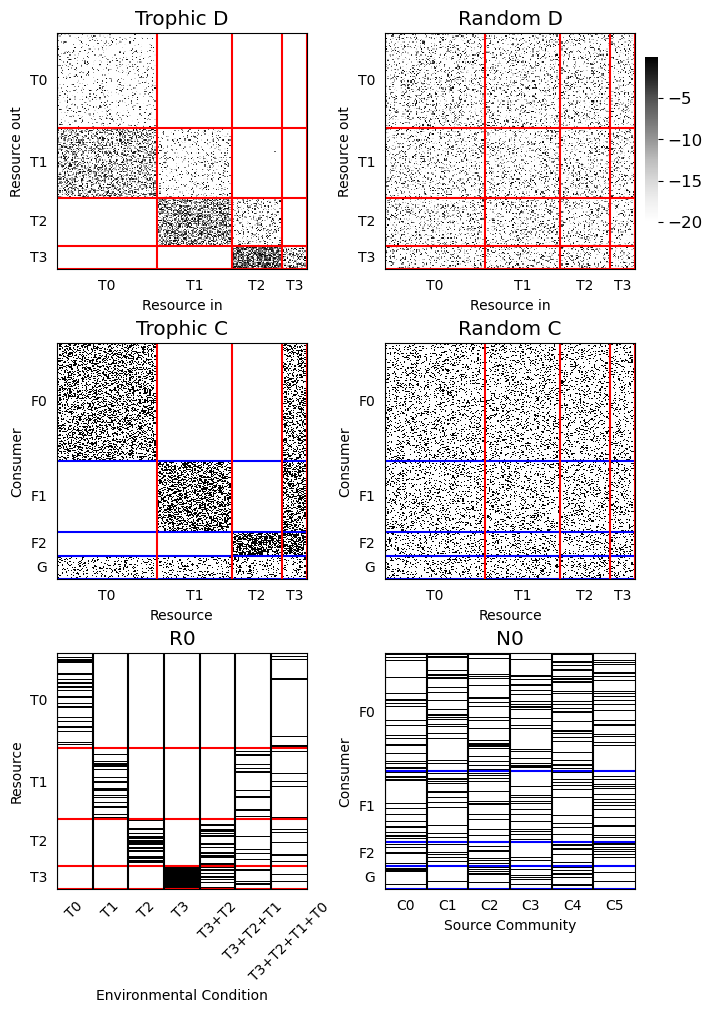

In [40]:
"Visualize"
resource_boundaries = resource_class_sizes.cumsum()
mean_resource_boundaries = pd.Series(np.append(0, resource_boundaries)).rolling(2).mean().dropna()
consumer_boundaries = weighted_class_sizes.cumsum()
mean_consumer_boundaries = pd.Series(np.append(0, consumer_boundaries)).rolling(2).mean().dropna()

fig, axs = plt.subplots(3, 2, figsize=(7, 10), layout='constrained')
with plt.rc_context({'font.size': 12}):
    # D matrices
    d_axs = axs[0]
    cax = None
    for ax, d_mat, d_name, cbar in zip(d_axs, [D_trophic, D_noisy], ['Trophic', 'Random'], [False, True]):
        if cbar:
            cax = ax.inset_axes([1.04, .2, .05, .7])
        sns.heatmap(d_mat.apply(np.log10).replace(-np.inf, np.nan), cmap='Greys', cbar=cbar, ax=ax, vmin=-20, cbar_ax=cax)
        ax.vlines(resource_boundaries, *ax.get_xlim(), color='r')
        ax.hlines(resource_boundaries, *ax.get_ylim(), color='r')
        ax.set_xlabel('Resource in')
        ax.set_ylabel('Resource out')
        ax.set_xticks(mean_resource_boundaries, ['T0', 'T1', 'T2', 'T3'], rotation=0)
        ax.set_yticks(mean_resource_boundaries, ['T0', 'T1', 'T2', 'T3'], rotation=0)
        ax.tick_params(bottom=False, left=False)
        ax.set_title(f'{d_name} D')
        for _, spine in ax.spines.items():
            spine.set_visible(True)
    
    # C matrices
    c_axs = axs[1]
    c_types = ['trophic', 'random']
    for ax, c_mat, c_name in zip(c_axs, [C_trophic, C_noisy], c_types):
        sns.heatmap(c_mat, cmap='Greys', cbar=False, ax=ax)
        ax.hlines(consumer_boundaries, *ax.get_xlim(), color='b')
        ax.vlines(resource_boundaries, *ax.get_ylim(), color='r')
        ax.set_xlabel('Resource')
        ax.set_ylabel('Consumer')
        ax.tick_params(bottom=False, left=False)
        ax.set_xticks(mean_resource_boundaries, ['T0', 'T1', 'T2', 'T3'], rotation=0)
        ax.set_yticks(mean_consumer_boundaries, ['F0', 'F1', 'F2', 'G'], rotation=0)
        ax.set_title(f'{c_name.capitalize()} C')
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            
    # Initial conditions
    init_condition_axs = axs[2]
    sns.heatmap(pd.DataFrame(R0s), cmap='Greys', ax=init_condition_axs[0], cbar=False)
    init_condition_axs[0].tick_params('x', rotation=45)
    init_condition_axs[0].hlines(resource_boundaries, *init_condition_axs[0].get_xlim(), color='r')
    init_condition_axs[0].set_ylabel('Resource')
    init_condition_axs[0].set_xlabel('Environmental Condition')
    init_condition_axs[0].set_yticks(mean_resource_boundaries, ['T0', 'T1', 'T2', 'T3'], rotation=0)
    init_condition_axs[0].set_title('R0')
    
    init_comms = N0s_df[md[md.condition.eq('T0') & md.D_type.eq('noisy') & md.c_type.eq('noisy')].index]
    sns.heatmap(pd.DataFrame(init_comms), cmap='Greys', ax=init_condition_axs[1], cbar=False)
    init_condition_axs[1].set_xticklabels([f'C{i}' for i in range(6)], rotation=0)
    init_condition_axs[1].hlines(consumer_boundaries, *ax.get_xlim(), color='b')
    init_condition_axs[1].set_yticks(mean_consumer_boundaries, ['F0', 'F1', 'F2', 'G'], rotation=0)
    init_condition_axs[1].set_ylabel('Consumer')
    init_condition_axs[1].set_xlabel('Source Community')
    init_condition_axs[1].set_title('N0')
    
    for ax in init_condition_axs:
        ax.tick_params(bottom=False, left=False)
        ax.vlines(range(len(ax.get_xticklabels())), *ax.get_ylim(), color='k')
        for _, spine in ax.spines.items():
            spine.set_visible(True)
plt.savefig('publication_figures/crm_params_05-08_allT3', dpi=300, bbox_inches='tight')
plt.show()

# Simulate
Simulation executed [here](env_complexity_simulation.py).

In [41]:
"Simulation results"
n_df = pd.read_csv('data/simulation/simulation_results_n_05-08_allT3.csv')
total_abundance = n_df.groupby(['Sample', 'time']).abundance.sum().reset_index(name='total_abundance')
n_df = n_df.merge(total_abundance)
n_df['relative_abundance'] = n_df.abundance / n_df.total_abundance
# Remove super small abundances
n_df.loc[n_df.relative_abundance.lt(1e-7), 'relative_abundance'] = 0
n_df.loc[n_df.abundance.lt(1e-7), 'abundance'] = 0
n_df = n_df.merge(md.reset_index())
n_df.head()

,time,species,abundance,Sample,total_abundance,relative_abundance,community_size,community,D_type,c_type,condition,scheme
0,0.0,0,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic
1,0.0,5,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic
2,0.0,6,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic
3,0.0,7,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic
4,0.0,17,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic


In [42]:
"Check profiles"
species2fam = {s[1].strip('S'): s[0] for s in c.index}
first_pass = n_df[n_df.D_type.eq('trophic') & n_df.c_type.eq('trophic')].astype({'species': str})
first_pass['family'] = first_pass.species.map(species2fam).replace('F3', 'G')
first_pass.head()

,time,species,abundance,Sample,total_abundance,relative_abundance,community_size,community,D_type,c_type,condition,scheme,family
0,0.0,0,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic,F0
1,0.0,5,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic,F0
2,0.0,6,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic,F0
3,0.0,7,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic,F0
4,0.0,17,1.0,S0,200.0,0.005,200,0,trophic,trophic,T0,200_trophic_trophic,F0


In [ ]:
g = sns.relplot(x='time', y='abundance', hue='family', data=first_pass, kind='line', col='condition', row='community', height=2, units='species', estimator=None, alpha=.2)
g.set(xscale='log', yscale='log')
g.set_titles('{row_name}|{col_name}')
g.set_xlabels('Time')
g.set_ylabels('Abundance')
plt.show()

In [54]:
"Compute divergence on final timepoint"
t = n_df.iloc[n_df.time.sub(300).abs().argmin()].time
n_final_time = n_df[n_df.time.eq(500)]
richness = n_final_time.groupby('Sample', group_keys=False).apply(lambda x: (x.abundance > 0).sum()).reset_index(name='richness').merge(md.reset_index())
richness.head()

,Sample,richness,community_size,community,D_type,c_type,condition,scheme
0,S0,22,200,0,trophic,trophic,T0,200_trophic_trophic
1,S1,41,200,0,trophic,noisy,T0,200_trophic_noisy
2,S10,21,200,0,noisy,trophic,T2,200_noisy_trophic
3,S100,12,200,3,trophic,trophic,T3+T2,200_trophic_trophic
4,S101,15,200,3,trophic,noisy,T3+T2,200_trophic_noisy


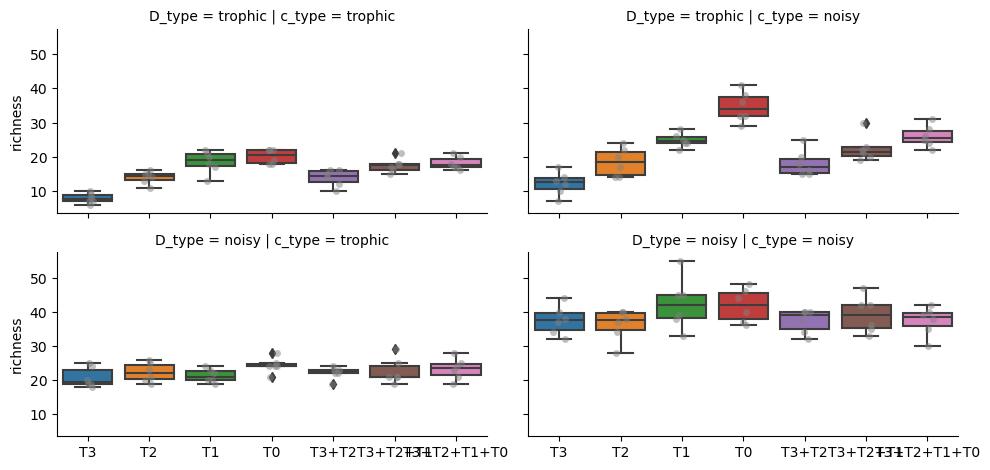

In [55]:
"Richness by condition with trophic D"
order = ['T3', 'T2', 'T1', 'T0', 'T3+T2', 'T3+T2+T1', 'T3+T2+T1+T0']
kwargs = dict(x='condition', y='richness', hue_order=order,  order=order)
g = sns.catplot(**kwargs, col='c_type', row='D_type', height=2.5, aspect=2, kind='box', col_order=['trophic', 'noisy'], row_order=['trophic', 'noisy'], data=richness)
g.map_dataframe(sns.stripplot, **kwargs, dodge=True, color='.5', alpha=.5)
g.set_xlabels('')
plt.show()

# Divergence

In [56]:
"Divergence"
# Normalize abundances between 0 and 8000 (random distribution of depth produces sam result)
minmax_normed = n_final_time.groupby('Sample', group_keys=False).apply(lambda x: pd.DataFrame(dict(zip(['Sample', 'species', 'normed'], [x.Sample, x.species, minmax_scale(x.abundance, (0, 8000))]))))
# Compute CLR transform
clred = minmax_normed.groupby('Sample', group_keys=False).apply(lambda x: pd.DataFrame(dict(zip(['Sample', 'species', 'clr'], [x.Sample, x.species, clr(x.normed.add(1))])))).merge(md.reset_index())
# Compute distances
# all_dists = n_final_time.groupby(['scheme', 'condition']).apply(lambda x: longDists(x, values='relative_abundance'))
all_dists = clred.groupby(['scheme', 'condition']).apply(lambda x: longDists(x, values='clr'))
paired_dists = all_dists.reset_index()
paired_dists = paired_dists[paired_dists.sample1.ne(paired_dists.sample2)]
paired_dists_md = paired_dists.scheme.str.split('_', expand=True).rename(columns=dict(enumerate(['community_size', 'D_type', 'c_type', 'leakage'])))
paired_dists = paired_dists.join(paired_dists_md).astype({'community_size': int})
derep = derep_pairs(paired_dists)
paired_dists.head()

,scheme,condition,sample1,sample2,dist,community_size,D_type,c_type
1,200_noisy_noisy,T0,S115,S143,41.233819,200,noisy,noisy
2,200_noisy_noisy,T0,S115,S3,44.760279,200,noisy,noisy
3,200_noisy_noisy,T0,S115,S31,42.633492,200,noisy,noisy
4,200_noisy_noisy,T0,S115,S59,42.704461,200,noisy,noisy
5,200_noisy_noisy,T0,S115,S87,42.310751,200,noisy,noisy


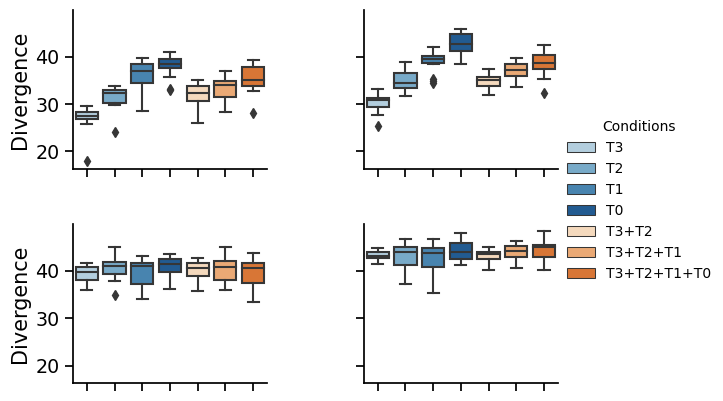

In [57]:
"Richness by condition with trophic D"
# Aesthetics
with open('data/aesthetics.pkl', 'rb') as fh:
    aesthetics = pickle.load(fh)
conditions, condition_name_pal, condition_pal, sites, site_pal = [a for a in aesthetics.values()]
order = ['T3', 'T2', 'T1', 'T0', 'T3+T2', 'T3+T2+T1', 'T3+T2+T1+T0']
condition_pal = dict(zip(order, list(condition_pal.values())[1:]))
kwargs = dict(x='condition', y='dist', hue_order=order,  order=order)
with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.catplot(**kwargs, hue='condition', dodge=False, col='c_type', row='D_type', height=2.5, aspect=1.2, kind='box', col_order=['trophic', 'noisy'], row_order=['trophic', 'noisy'], data=derep, palette=condition_pal)
#     g.map_dataframe(sns.stripplot, **kwargs, dodge=True, color='.7', alpha=.3)
    g.set_ylabels('Divergence')
    g.set_titles('')
g.add_legend(title='Conditions')
g.set_xlabels('')
g.set_xticklabels('')
plt.show()